In [2]:
import rasterio as rio
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import geopandas as gpd

<>:1: SyntaxWarning: invalid escape sequence '\A'
<>:1: SyntaxWarning: invalid escape sequence '\A'
C:\Users\esl26\AppData\Local\Temp\ipykernel_45184\2781205995.py:1: SyntaxWarning: invalid escape sequence '\A'
  shp = gpd.read_file('../data/angola_shp\AGO_adm0.shp')


<Axes: >

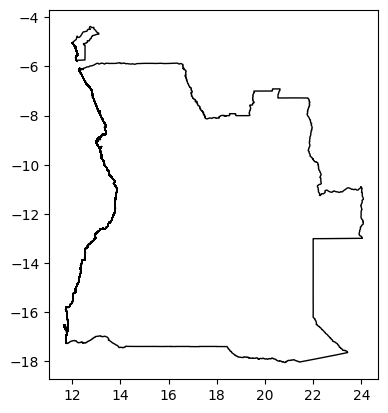

In [3]:
shp = gpd.read_file('../data/angola_shp\AGO_adm0.shp')
shp.geometry.boundary.plot(color=None, edgecolor='k', linewidth = 1)

In [6]:
tif_sample = "../data/rszm/2023_07_07.tif"
with rio.open(tif_sample) as src:
    sm = src.read(1)
    bounds = src.bounds
    crs = src.crs
sm.shape, bounds, crs

((189, 133),
 BoundingBox(left=11.716805458068848, bottom=-17.973846435546875, right=24.040456771850586, top=-4.4174346923828125),
 CRS.from_epsg(4326))

In [7]:
values = np.unique(sm)[:-1] # remove the NaN value
values, np.min(values), np.max(values)

(array([0.03339461, 0.03413701, 0.0342106 , ..., 0.48781778, 0.49074804,
        0.50156528]),
 0.03339460945915013,
 0.5015652753857304)

# Visualize TIFF file

c:\Users\esl26\AppData\Local\anaconda3\envs\research\Lib\site-packages\cartopy\mpl\gridliner.py:463: UserWarning: The .xlabels_bottom attribute is deprecated. Please use .bottom_labels to toggle visibility instead.
  warnings.warn('The .xlabels_bottom attribute is deprecated. Please '
c:\Users\esl26\AppData\Local\anaconda3\envs\research\Lib\site-packages\cartopy\mpl\gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


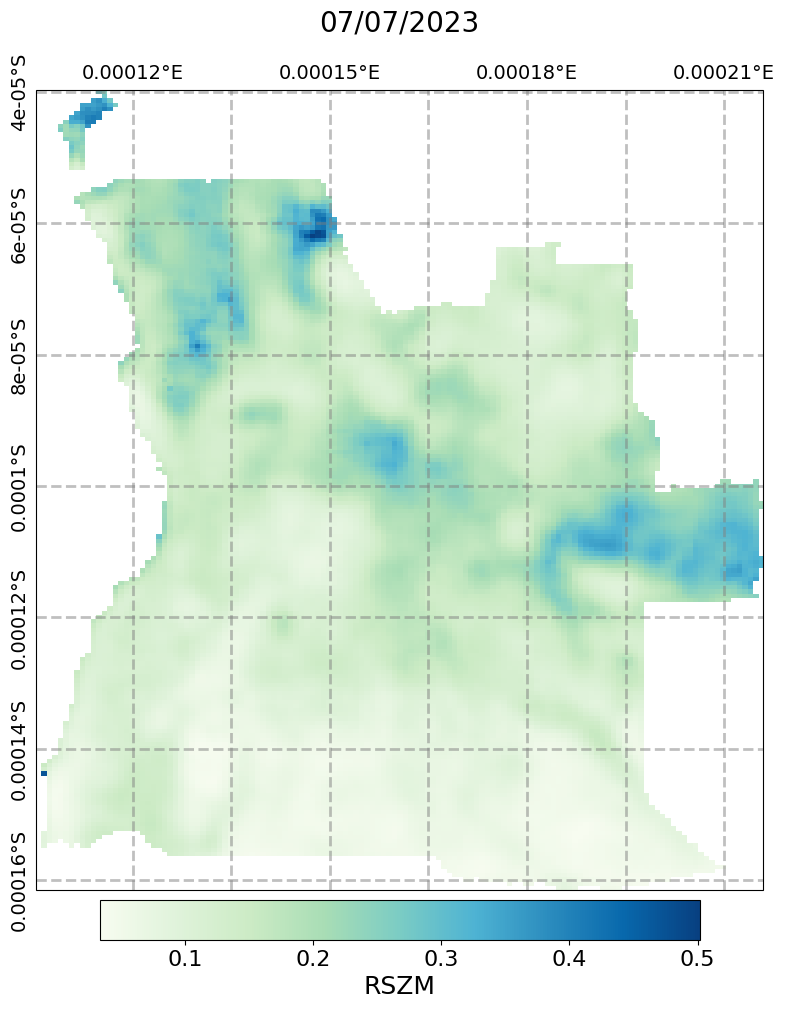

In [8]:
fig = plt.figure(figsize=(10, 10))
img_extent = (bounds.left, bounds.right, bounds.bottom, bounds.top)
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8], projection=ccrs.epsg(3857)) 
#TODO: understand what the params mean
#TODO: undertstand diff between projections

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='gray',
                  alpha=0.5, linestyle='--', ylabel_style={'size': 14, 'rotation': 'vertical'}, 
                  xlabel_style={'size': 14}) #TODO: insert line styles later

gl.xlabels_bottom = False
gl.ylabels_right = False

plot = ax.imshow(sm, cmap='GnBu', extent=img_extent)

cbar_ax = fig.add_axes([0.20, 0.05, 0.6, 0.04])
cbar = plt.colorbar(plot, cax=cbar_ax, orientation='horizontal', pad=0.05)
cbar.ax.tick_params(labelsize=16)
cbar.set_label('RSZM', fontsize=18)

fig.suptitle('07/07/2023', fontsize=20)

plt.savefig('../figures/rszm_sample.png', dpi=300, bbox_inches='tight')